In [ ]:
import os
import pandapower as ppw
import warnings
warnings.filterwarnings(action = "ignore", category = FutureWarning)
import pandas as pd
pd.option_context('future.no_silent_downcasting', True)
import numpy as np

from pandapower.control.controller.trafo.DiscreteTapControl import DiscreteTapControl
from pandapower.control.util.characteristic import Characteristic
from pandapower.plotting.plotly.mapbox_plot import set_mapbox_token
set_mapbox_token(os.getenv("MAPBOX_TOKEN"))
from src.toolbox import appliquer_coeffs, afficher_tensions, afficher_lignes_modifiables, afficher_interrupteurs

Vous trouverez ici le [sujet](data/Sujet_TP_BUT_GE2I_Seance1.pdf)

# I - Visualisation d'un départ HTA

## 1 - Départ sans transformateur

### Départ à vide

In [ ]:
depart_sans_transfo = ppw.from_pickle("data/Depart_sans_transfo.p")
ppw.runpp(depart_sans_transfo, numba = False)
afficher_tensions(depart_sans_transfo)

### Départ en scénario "hiver"

In [ ]:
appliquer_coeffs(depart_sans_transfo, coeff_charge = 0.2, coeff_prod = 0)
ppw.runpp(depart_sans_transfo, numba = False)
afficher_tensions(depart_sans_transfo)

### Départ en scénario "été"

In [ ]:
appliquer_coeffs(depart_sans_transfo, coeff_charge = 0.04, coeff_prod = 1)
ppw.runpp(depart_sans_transfo, numba = False)
afficher_tensions(depart_sans_transfo)

### 1.1 Variations de tension en ligne

Expliquez les différences que vous pouvez observer entre les différents scénarios, notamment en ce qui concerne les tensions et le bilan de puissance

## 2 - Départ avec transformateur

Vous trouverez ici la fiche technique du transformateur : [fiche technique](data/fiche_technique_transformateur_20MVA.pdf)

In [ ]:
depart_avec_transfo = ppw.from_pickle("data/Depart_avec_transfo.p")
transfo = depart_avec_transfo.trafo.index[-1]
bus_hta = depart_avec_transfo.trafo.at[transfo, "lv_bus"]

### 2.1 - Déterminez la bonne prise régleur pour les différents scénarios suivants

### Tension HTB = 90 kV + départ à vide

In [ ]:
depart_avec_transfo = ppw.from_pickle("data/Depart_avec_transfo.p")
depart_avec_transfo.ext_grid.at[0, "vm_pu"] = 1

depart_avec_transfo.trafo.at[transfo, "tap_pos"] = 9     #A modifier

ppw.runpp(depart_avec_transfo, numba = False)
print(depart_avec_transfo.res_bus.loc[bus_hta]["vm_pu"])
afficher_tensions(depart_avec_transfo)

### Tension HTB = 83 kV + "hiver"

In [ ]:
depart_avec_transfo = ppw.from_pickle("data/Depart_avec_transfo.p")
appliquer_coeffs(depart_avec_transfo, coeff_charge = 0.2, coeff_prod = 0)
depart_avec_transfo.ext_grid.at[0, "vm_pu"] = 83/90

depart_avec_transfo.trafo.at[transfo, "tap_pos"] = 9     #A modifier

ppw.runpp(depart_avec_transfo, numba = False)
print(depart_avec_transfo.res_bus.loc[bus_hta]["vm_pu"])
afficher_tensions(depart_avec_transfo)

### Tension HTB = 97 kV + "été"

In [ ]:
depart_avec_transfo = ppw.from_pickle("data/Depart_avec_transfo.p")
appliquer_coeffs(depart_avec_transfo, coeff_charge = 0.04, coeff_prod = 1)
depart_avec_transfo.ext_grid.at[0, "vm_pu"] = 97/90

depart_avec_transfo.trafo.at[transfo, "tap_pos"] = 9     #A modifier

ppw.runpp(depart_avec_transfo, numba = False)
print(depart_avec_transfo.res_bus.loc[bus_hta]["vm_pu"])
afficher_tensions(depart_avec_transfo)

### 2.2 Analyse des résultats

Expliquez les prises sélectionnées pour les différents scénarios, et les éventuelles limites rencontrées, en vous appuyant sur la fiche technique du transformateur

# II - Résolution des contraintes de surtension

On raccorde un nouveau producteur de 3 MW sur le départ :
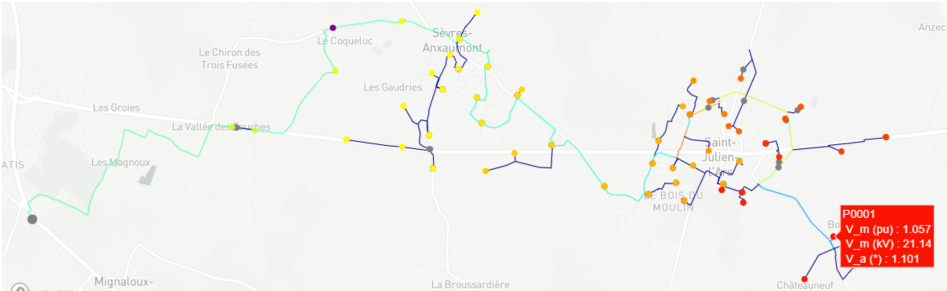

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)
ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

Comme on peut l'observer, ce nouveau producteur induit des contraintes de surtension. Que proposez-vous pour les résoudre ?

Nous allons maintenant étudier certaines méthodes de résolution des contraintes de surtension (liste non exhaustive).

## 1 - Changement de schéma d'exploitation

Sur le schéma ci-dessous, les interrupteurs fermés apparaissent en <span style="color:gray">gris</span> et les interrupteurs ouverts apparraissent en <span style="color:violet">violet</span>.

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)
ppw.runpp(depart_en_contrainte, numba = False)
afficher_interrupteurs(depart_en_contrainte)

Quelles manipulations d'organes de coupure effectuer pour résoudre les contraintes de surtension ?

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")

interrupteur_a_fermer = ""   #A compléter
interrupteur_a_ouvrir = ""   #A compléter

depart_en_contrainte.switch.at[depart_en_contrainte.switch.loc[depart_en_contrainte.switch["name"] == interrupteur_a_fermer].index[0], "closed"] = True
depart_en_contrainte.switch.at[depart_en_contrainte.switch.loc[depart_en_contrainte.switch["name"] == interrupteur_a_ouvrir].index[0], "closed"] = False

appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)
ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

## 2 - Consignes de puissance

### 2.1 - Limitation de la puissance active

À quelle puissance doit-on limiter le nouveau producteur pour garantir le respect des contraintes de tension ?

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
producteur = depart_en_contrainte.sgen.loc[depart_en_contrainte.sgen["name"] == "P0001"].index[0]
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)

pmax_prod = 3  #A modifier

depart_en_contrainte.sgen.at[producteur, "p_mw"] = pmax_prod

ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

### 2.2 - Consigne en tan($\phi$)

Quelle consigne en tan($\phi$) doit-on donner au producteur pour garantir le respect des contraintes de tension ?

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)

tan_phi = 0    #A modifier

depart_en_contrainte.sgen.at[producteur, "q_mvar"] = depart_en_contrainte.sgen.at[producteur, "p_mw"] * tan_phi

ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

### 2.3 - Consigne en tan($\phi$) et limitation de puissance 

En pratique, la norme fixe les limites de la consigne en tan($\phi$) que le GRD peut donner à un producteur entre -0.35 et 0.4. Compte tenu de ces limitations, à quelle puissance doit-on limiter le producteur pour garantir le respect des contraintes de tension ?

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)

tan_phi = 0      #A modifier
pmax_prod = 3    #A modifier

depart_en_contrainte.sgen.at[producteur, "p_mw"] = pmax_prod
depart_en_contrainte.sgen.at[producteur, "q_mvar"] = depart_en_contrainte.sgen.at[producteur, "p_mw"] * tan_phi

ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

## 3 - Renforcement du départ

Ci-dessous sont mises en évidence les lignes présentant les plus fortes variations de tension :  

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)
ppw.runpp(depart_en_contrainte, numba = False)
afficher_lignes_modifiables(depart_en_contrainte)

Lesquelles de ces lignes au minimum doit-on renforcer en câble 240 mm² pour garantir le respect des contraintes de tension ? 

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)

lignes_a_renforcer = []   #A compléter

for ligne in lignes_a_renforcer:
    depart_en_contrainte.line.at[ligne, "std_type"] = "Alu240 C33-226"
    depart_en_contrainte.line.at[ligne, "r_ohm_per_km"] = 0.125
    depart_en_contrainte.line.at[ligne, "x_ohm_per_km"] = 0.1
    depart_en_contrainte.line.at[ligne, "c_nf_per_km"] = 370
    depart_en_contrainte.line.at[ligne, "max_i_ka"] = 0.404

ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)

## 4 - Inductances de compensation de la puissance réactive

Déterminez lequel des 3 sites proposés est le meilleur pour implanter une inductance. Expliquez votre choix. 
Déterminez ensuite la puissance réactive minimale qui doit  être consommée par l'inductance pour garantir le respect des contraintes de tension.

In [ ]:
depart_en_contrainte = ppw.from_pickle("data/Depart_en_contrainte.p")
appliquer_coeffs(depart_en_contrainte, coeff_charge = 0.04, coeff_prod = 1)

q1 = 0   #A modifier
q2 = 0   #A modifier
q3 = 0   #A modifier

self1 = ppw.create_load(depart_en_contrainte, bus = 327, p_mw = 0, q_mvar = q1, name = "Self1")
self2 = ppw.create_load(depart_en_contrainte, bus = 328, p_mw = 0, q_mvar = q2, name = "Self2")
self3 = ppw.create_load(depart_en_contrainte, bus = 24, p_mw = 0, q_mvar = q3, name = "Self3")

ppw.runpp(depart_en_contrainte, numba = False)
afficher_tensions(depart_en_contrainte)